In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset/medicinal_weedy_area_image_dataset/val/10_pudina/pudina (379).jpg
/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset/medicinal_weedy_area_image_dataset/val/10_pudina/pudina (177).jpg
/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset/medicinal_weedy_area_image_dataset/val/10_pudina/pudina (328).jpg
/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset/medicinal_weedy_area_image_dataset/val/10_pudina/pudina (365).jpg
/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset/medicinal_weedy_area_image_dataset/val/10_pudina/pudina (196).jpg
/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset/medicinal_weedy_area_image_dataset/val/10_pudina/pudina (136).jpg
/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_im

# Code starts from here

Enter the path to your plant image:  /kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/test/2_7_akondo/akondo_augmentation (137).jpg
Enter your query about the plant (optional):  what is the modern uses of the plant


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


## ✅ Predicted Plant Class: **2_7_akondo**

**Prediction Confidence:** 99.97%

### 🔹 Top Predictions:

- **2_7_akondo**: 99.97%

- **3_10_tarulata**: 0.02%

- **7_32_nayontara**: 0.01%

- **6_27_bohera**: 0.00%

- **4_18_joba**: 0.00%

### 🔹 Human-like Plant Explanation

Calotropis procera (2_7_akondo) is a Perennial Shrub/Small tree in the Apocynaceae family. It naturally grows in Semi-arid regions, dry grasslands, waste areas, xerophytic habitats across Tropical Africa, Arabian Peninsula, Indian Subcontinent. Traditionally, it is used for Unani pain relief, traditional skin ulcer treatment, Ayurvedic wound care and contains active compounds like Cardenolides (cardiac glycosides), cardiac aglycones, alkaloids. Preferred cultivation conditions include Tropical-subtropical, 15-40°C, drought resistant, 400-1200mm rainfall and Well-drained sandy soil, poor soil tolerance. Safety considerations: ABSOLUTELY CONTRAINDICATED in pregnancy; cardiotoxic potential. Leaf features: Oblong-lanceolate, 6-12cm long, pubescent, waxy coating, opposite arrangement. 

### 💡 Query Answer

Unani pain relief, traditional skin ulcer treatment, Ayurvedic wound care

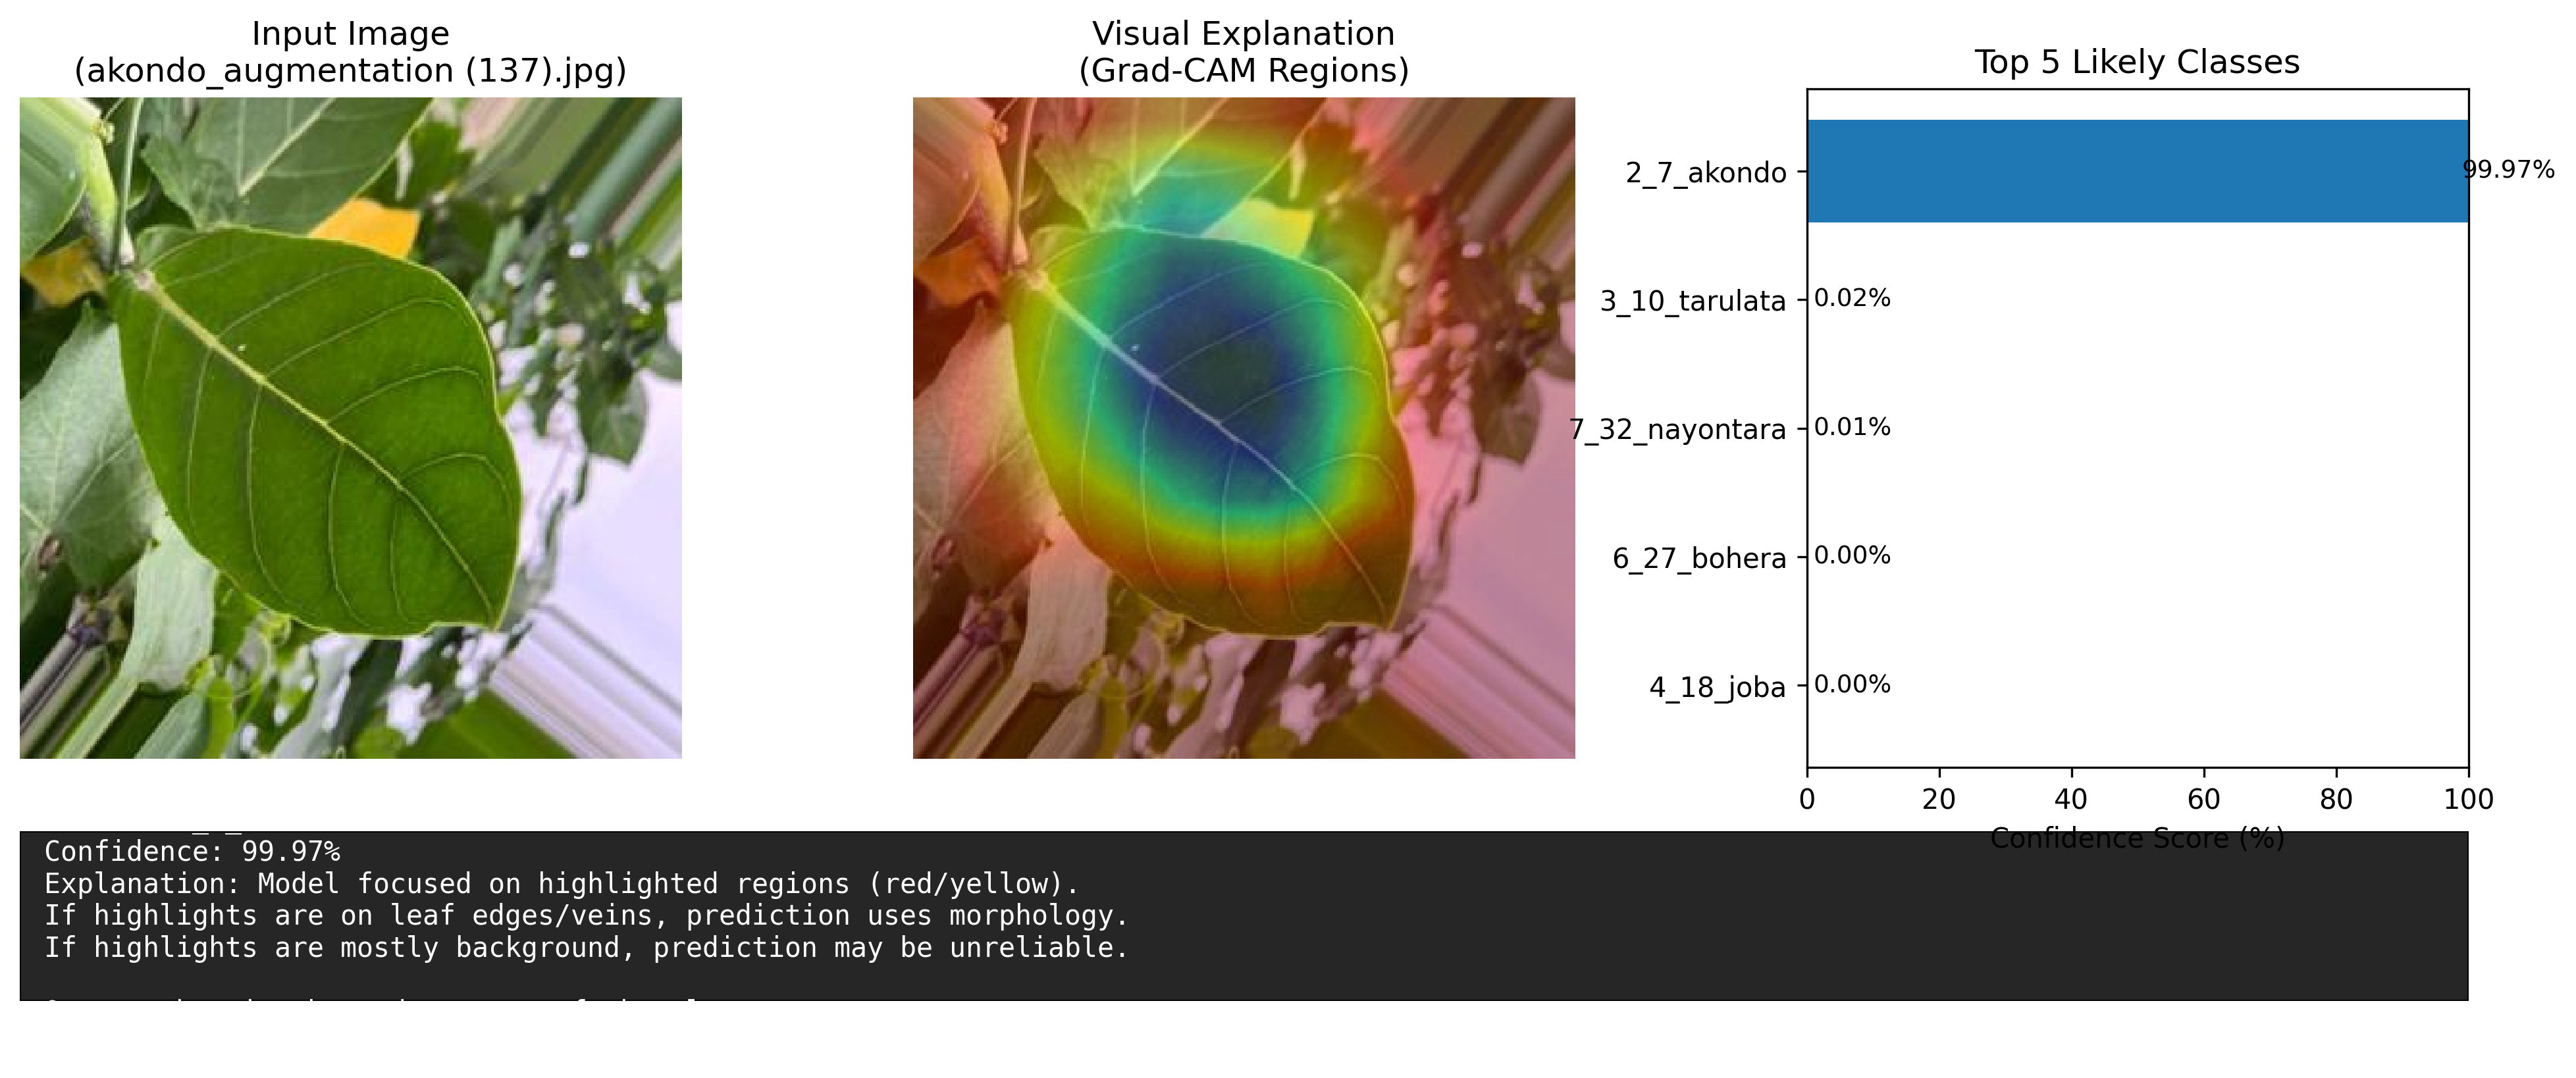

✅ Saved merged figure: `./outputs/akondo_augmentation (137)_merged_gradcam_top5_300dpi.png` and `./outputs/akondo_augmentation (137)_merged_gradcam_top5.pdf`

Enter dataset root folder for t-SNE (e.g., .../test):  /kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/test


### 🧬 t-SNE Setup

- Embedding layer: `global_average_pooling2d`

- Sampling up to `30` images per class

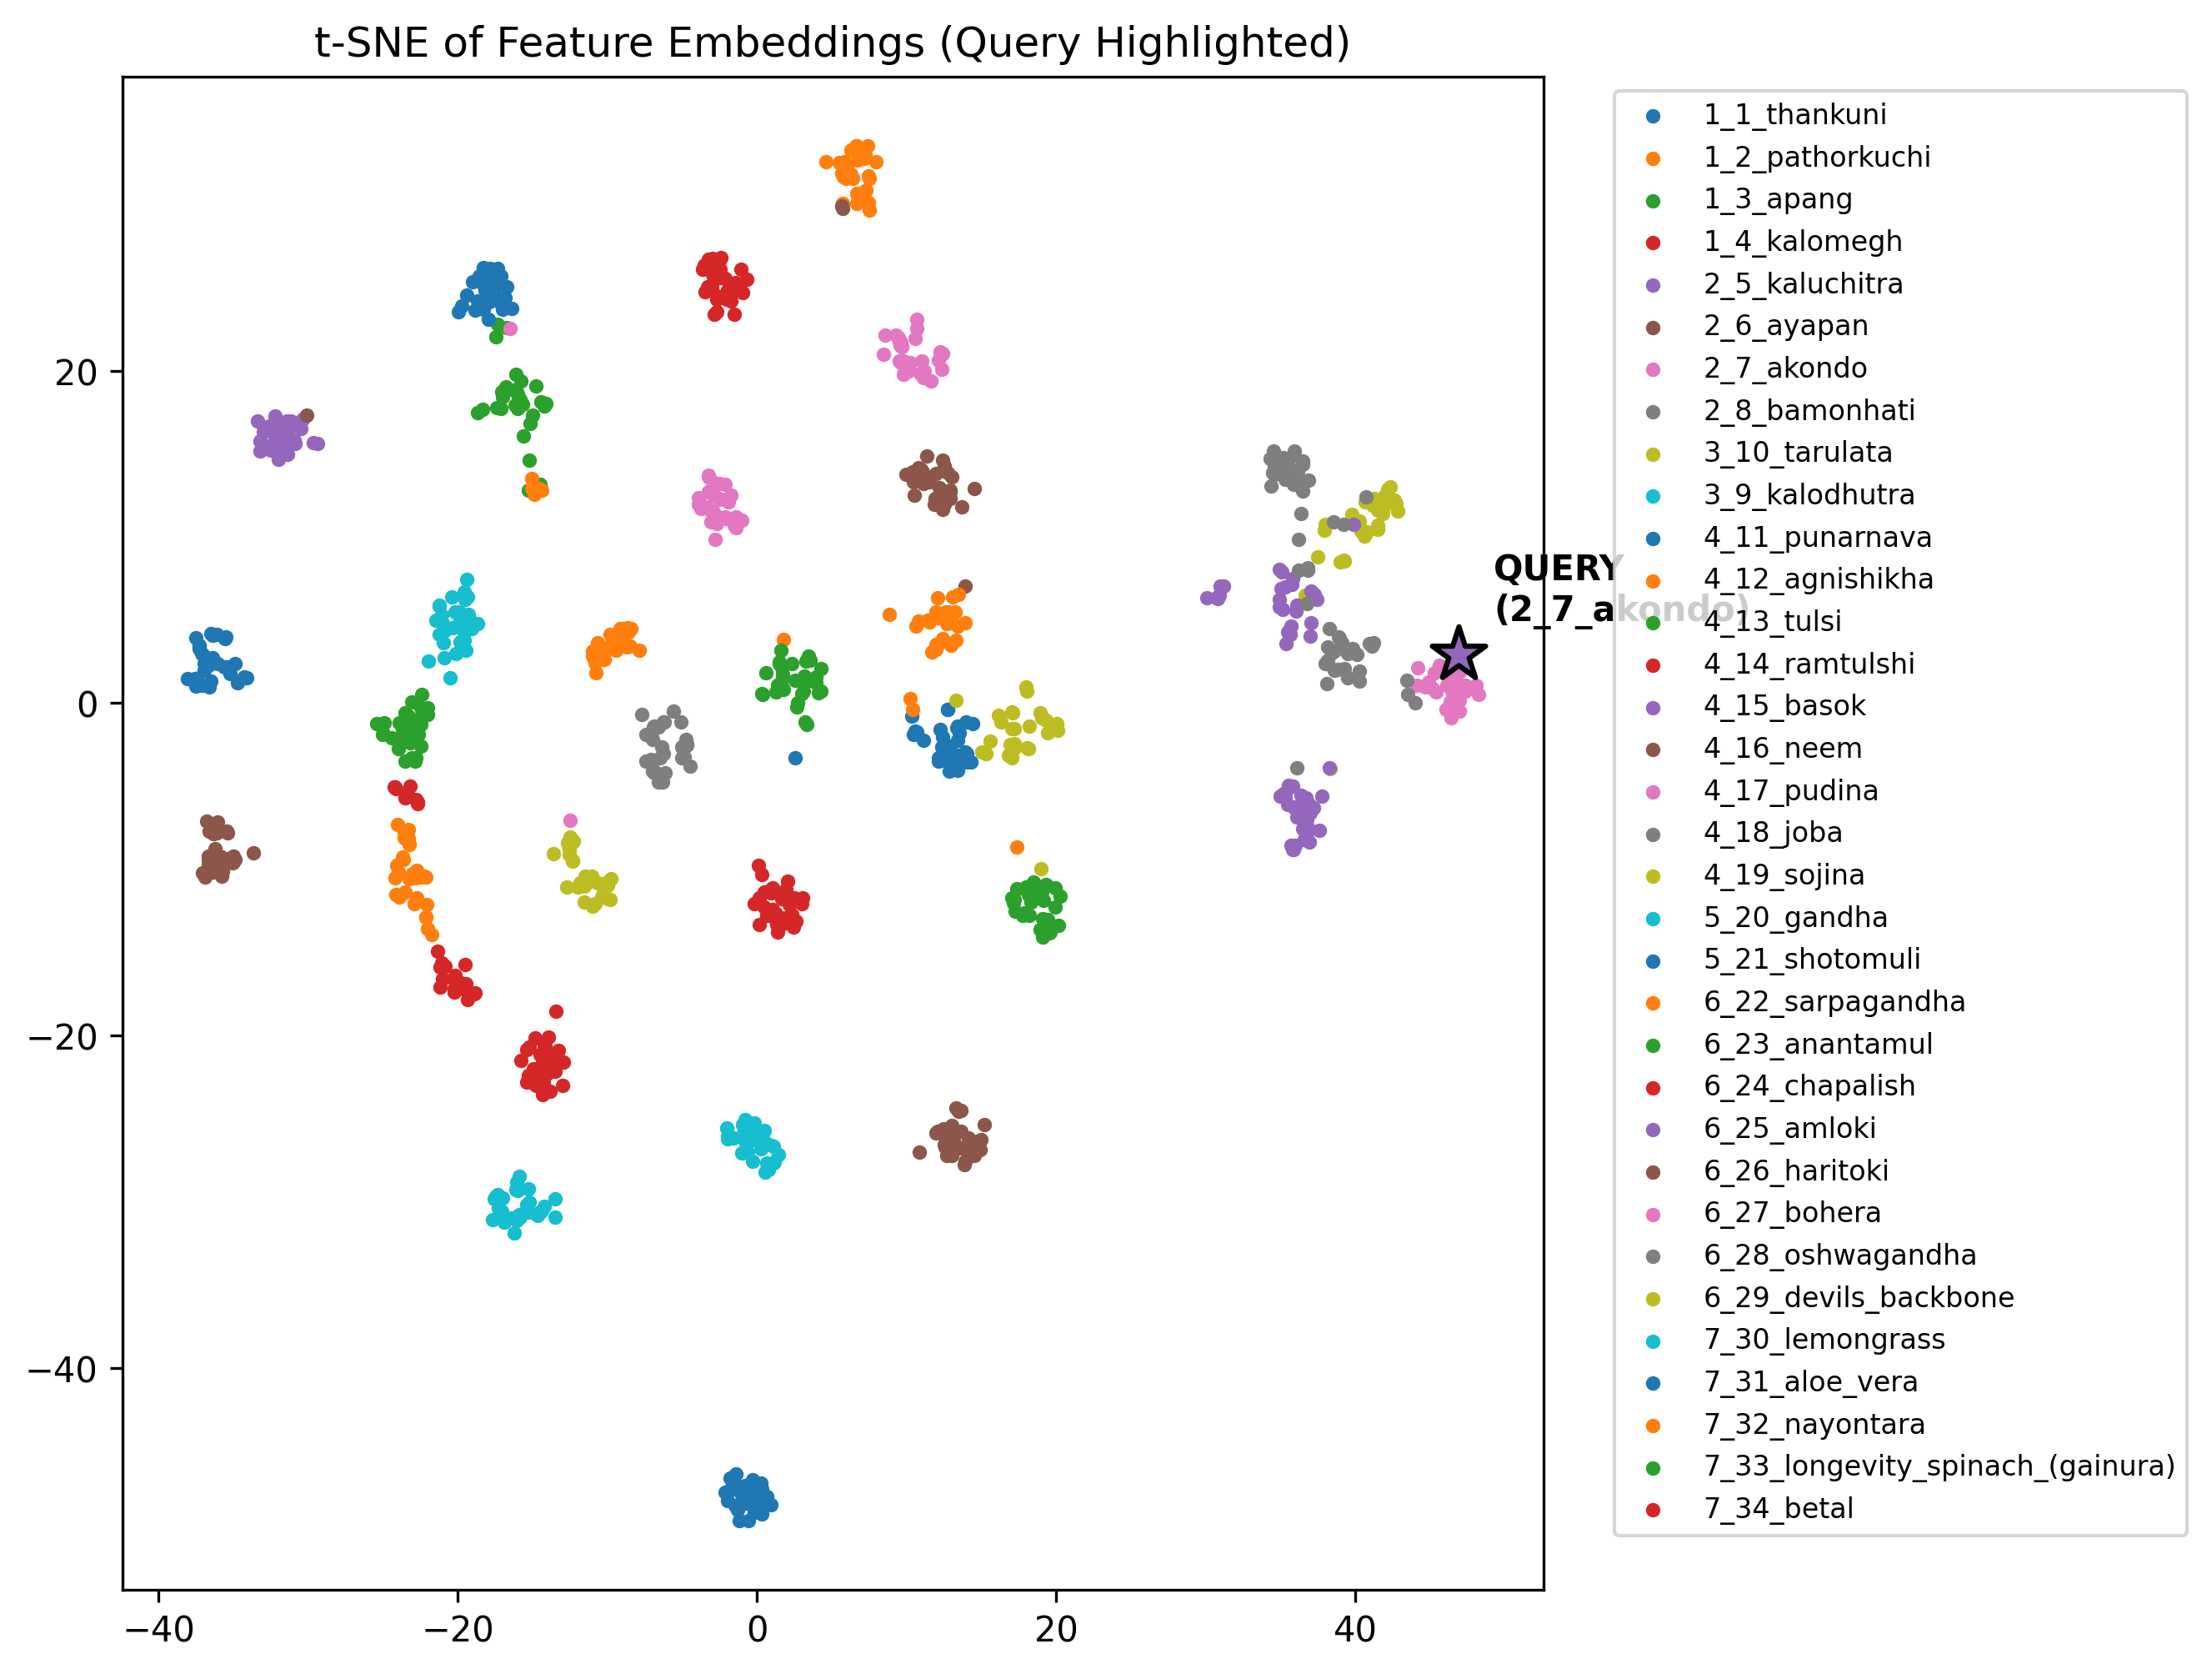

✅ Saved t-SNE plot (query highlighted): `./outputs/tsne_with_query_test_300dpi.png`

In [6]:
# ============================================
# CLEAN FULL PIPELINE (QUIET LOGS) + MERGED FIGURE (300 DPI) + OPTIONAL t-SNE
# ============================================

# ---- Must be FIRST (before importing TF) ----
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suppress TF C++ logs (most of the noise)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0" # optional: reduce extra backend logs

import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from IPython.display import display, Markdown

# Optional t-SNE (set ENABLE_TSNE=True)
from sklearn.manifold import TSNE

# -------------------------------
# PATHS
# -------------------------------
MODEL_PATH = "/kaggle/input/llm-rag-medinet-xg-work-json-csv-h5/medicinal_plant_classifier.h5"
JSON_PATH  = "/kaggle/input/llm-rag-medinet-xg-work-json-csv-h5/leaf_data.json"

# -------------------------------
# SETTINGS
# -------------------------------
ENABLE_TSNE = True           # set False if you don't need t-SNE
TSNE_MAX_PER_CLASS = 30      # how many images per class to sample (speed control)
TSNE_PERPLEXITY = 30         # typical 5-50
TSNE_RANDOM_STATE = 42
SAVE_DIR = "./outputs"
SAVE_PDF = True              # also save vector pdf
TOP_K = 5

# -------------------------------
# QUIET PYTHON/TF LOGS
# -------------------------------
tf.get_logger().setLevel("ERROR")
try:
    tf.autograph.set_verbosity(0)
except Exception:
    pass

# -------------------------------
# LOAD JSON + MODEL (quiet inference; avoids "compiled metrics" warning)
# -------------------------------
with open(JSON_PATH, "r", encoding="utf-8") as f:
    plant_data = json.load(f)

model = load_model(MODEL_PATH, compile=False)  # compile=False removes metrics warning
class_keys = sorted(list(plant_data.keys()))

# -------------------------------
# IMAGE PREPROCESSING
# -------------------------------
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0)

# -------------------------------
# PREDICT (Top-K)
# -------------------------------
def predict_plant_class(img_path, top_k=5):
    x = load_and_preprocess_image(img_path)
    preds = model.predict(x, verbose=0)[0]
    top_idx = preds.argsort()[-top_k:][::-1]
    top = [(class_keys[i], float(preds[i]) * 100.0) for i in top_idx]
    return top[0][0], top[0][1], top, x, preds

# -------------------------------
# JSON EXPLANATION + QUERY ANSWER
# -------------------------------
def generate_human_like_explanation(plant_key):
    info = plant_data.get(plant_key, {})
    if not info:
        return "No information available."

    text = f"{info.get('Scientific Name','Unknown')} ({plant_key}) is a {info.get('Life Span','')} {info.get('Plant Habit','')} in the {info.get('Botanical Family','')} family. "
    text += f"It naturally grows in {info.get('Native Habitat','')} across {info.get('Geographical Origin','')}. "
    text += f"Traditionally, it is used for {info.get('Traditional Uses','')} and contains active compounds like {info.get('Primary Active Compounds','')}. "
    text += f"Preferred cultivation conditions include {info.get('Climate Requirements','')} and {info.get('Preferred Soil Type','')}. "
    text += f"Safety considerations: {info.get('Pregnancy & Lactation Safety','')}. "
    text += f"Leaf features: {info.get('Leaf Morphology','')}. "
    return text

def answer_query(plant_key, query):
    info = plant_data.get(plant_key, {})
    if not info:
        return "No plant information found."

    q = query.lower()
    keywords = {
        "scientific": "Scientific Name",
        "botanical": "Botanical Family",
        "genus": "Genus & Species",
        "family": "Botanical Family",
        "leaf": "Leaf Morphology",
        "life": "Life Span",
        "habitat": "Native Habitat",
        "origin": "Geographical Origin",
        "uses": "Traditional Uses",
        "medicinal": "Therapeutic Properties",
        "dosage": "Standard Dosage",
        "toxic": "Toxicity Levels",
        "safety": "Pregnancy & Lactation Safety",
        "interaction": "Drug-Herb Interactions",
        "country": "Geographical Origin",
        "soil": "Preferred Soil Type",
        "climate": "Climate Requirements"
    }
    for key, json_key in keywords.items():
        if key in q:
            return info.get(json_key, "No information available for this query.")
    return "I cannot answer this question because it is outside my knowledge base."

# -------------------------------
# GRAD-CAM
# -------------------------------
def grad_cam(model, img_array, class_idx=None, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if "conv" in layer.name:
                last_conv_layer_name = layer.name
                break
    if last_conv_layer_name is None:
        raise ValueError("No convolutional layer found in model.")

    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = int(np.argmax(predictions[0]))
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    return cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

# -------------------------------
# REPORT TEXT (bottom panel)
# -------------------------------
def build_analysis_report(predicted_class, confidence, user_query=None, query_answer=None):
    lines = [
        "--- Analysis Report ---",
        f"Result: {predicted_class}",
        f"Confidence: {confidence:.2f}%",
        "Explanation: Model focused on highlighted regions (red/yellow).",
        "If highlights are on leaf edges/veins, prediction uses morphology.",
        "If highlights are mostly background, prediction may be unreliable."
    ]
    if user_query:
        lines += ["", f"Query: {user_query}", f"Answer: {query_answer if query_answer else 'N/A'}"]
    return "\n".join(lines)

# -------------------------------
# t-SNE SUPPORT (features from penultimate layer)
# -------------------------------
def build_embedding_model(base_model):
    # Pick a good embedding layer automatically:
    # prefer GlobalAveragePooling, otherwise last layer before final Dense.
    layer_name = None
    for layer in reversed(base_model.layers):
        name = layer.name.lower()
        if "global_average_pooling" in name or "gap" == name:
            layer_name = layer.name
            break
    if layer_name is None:
        # fallback: take second-to-last layer output
        layer_name = base_model.layers[-2].name

    emb_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    return emb_model, layer_name

def get_embedding(embed_model, img_path):
    x = load_and_preprocess_image(img_path)
    v = embed_model.predict(x, verbose=0)
    return v.squeeze()

def collect_tsne_samples_from_kaggle_dataset(root_dir, max_per_class=30, exts=(".jpg", ".jpeg", ".png")):
    """
    root_dir should point to a folder where subfolders are class names (like Kaggle test/ or train/).
    Returns list of (img_path, class_label)
    """
    samples = []
    if not os.path.isdir(root_dir):
        raise FileNotFoundError(f"t-SNE root_dir not found: {root_dir}")

    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        count = 0
        for fn in os.listdir(cls_path):
            if fn.lower().endswith(exts):
                samples.append((os.path.join(cls_path, fn), cls))
                count += 1
                if count >= max_per_class:
                    break
    return samples

def compute_tsne_map(samples, embed_model, perplexity=30, random_state=42):
    X = np.array([get_embedding(embed_model, p) for p, _ in samples])
    y = np.array([lab for _, lab in samples])

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=random_state
    )
    Z = tsne.fit_transform(X)
    return Z, y

def plot_tsne(Z, y, title="t-SNE of Feature Embeddings", save_path=None, dpi=300):
    plt.figure(figsize=(9, 7), dpi=dpi)
    for cls in np.unique(y):
        idx = (y == cls)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=10, label=cls)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()

# -------------------------------
# MERGED FIGURE PIPELINE (+ optional t-SNE generation)
# -------------------------------
def process_plant_image_interactive_merged(top_k=5, save_dir="./outputs", save_pdf=True, enable_tsne=True):
    img_path = input("Enter the path to your plant image: ").strip()
    user_query = input("Enter your query about the plant (optional): ").strip()

    predicted_class, confidence, top_classes, img_array, _ = predict_plant_class(img_path, top_k=top_k)
    human_expl = generate_human_like_explanation(predicted_class)
    query_answer = answer_query(predicted_class, user_query) if user_query else ""

    heatmap = grad_cam(model, img_array)
    overlay_img = overlay_heatmap(img_path, heatmap)

    # Load original for panel 1
    orig_bgr = cv2.imread(img_path)
    if orig_bgr is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # bar chart data
    labels = [c for c, _ in top_classes][::-1]
    scores = [p for _, p in top_classes][::-1]

    # Merged figure (publication-ready)
    fig = plt.figure(figsize=(16, 6), dpi=300)
    gs = fig.add_gridspec(2, 3, height_ratios=[4, 1], wspace=0.35, hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(orig_rgb)
    ax1.set_title(f"Input Image\n({os.path.basename(img_path)})", fontsize=12)
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(overlay_img)
    ax2.set_title("Visual Explanation\n(Grad-CAM Regions)", fontsize=12)
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.barh(labels, scores)
    ax3.set_xlim(0, 100)
    ax3.set_xlabel("Confidence Score (%)")
    ax3.set_title(f"Top {top_k} Likely Classes", fontsize=12)
    for i, v in enumerate(scores):
        ax3.text(min(v + 1, 99), i, f"{v:.2f}%", va="center", fontsize=9)

    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis("off")
    report_text = build_analysis_report(
        predicted_class,
        confidence,
        user_query if user_query else None,
        query_answer if user_query else None
    )
    ax4.add_patch(plt.Rectangle((0, 0), 1, 1, transform=ax4.transAxes, color="black", alpha=0.85))
    ax4.text(0.01, 0.5, report_text, transform=ax4.transAxes,
             fontsize=10, color="white", va="center", family="monospace")

    # Notebook text (like your example screenshot)
    display(Markdown(f"## ✅ Predicted Plant Class: **{predicted_class}**"))
    display(Markdown(f"**Prediction Confidence:** {confidence:.2f}%"))
    display(Markdown("### 🔹 Top Predictions:"))
    for c, p in top_classes:
        display(Markdown(f"- **{c}**: {p:.2f}%"))
    display(Markdown("### 🔹 Human-like Plant Explanation"))
    display(Markdown(human_expl))
    if user_query:
        display(Markdown("### 💡 Query Answer"))
        display(Markdown(query_answer))

    # Save merged figure
    os.makedirs(save_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_png = os.path.join(save_dir, f"{base}_merged_gradcam_top{top_k}_300dpi.png")
    fig.savefig(out_png, dpi=300, bbox_inches="tight")

    out_pdf = None
    if save_pdf:
        out_pdf = os.path.join(save_dir, f"{base}_merged_gradcam_top{top_k}.pdf")
        fig.savefig(out_pdf, bbox_inches="tight")

    plt.show()
    display(Markdown(f"✅ Saved merged figure: `{out_png}`" + (f" and `{out_pdf}`" if out_pdf else "")))

    # -----------------------
    # OPTIONAL: t-SNE (MARK current input image point) + save 300 DPI
    # -----------------------
    if enable_tsne:
        # CHANGE THIS to your dataset root (folder contains class subfolders)
        TSNE_ROOT = input("Enter dataset root folder for t-SNE (e.g., .../test): ").strip()

        embed_model, emb_layer = build_embedding_model(model)
        display(Markdown(f"### 🧬 t-SNE Setup"))
        display(Markdown(f"- Embedding layer: `{emb_layer}`"))
        display(Markdown(f"- Sampling up to `{TSNE_MAX_PER_CLASS}` images per class"))

        # 1) collect dataset samples
        samples = collect_tsne_samples_from_kaggle_dataset(
            TSNE_ROOT, max_per_class=TSNE_MAX_PER_CLASS
        )

        # 2) compute dataset embeddings
        X_data = np.array([get_embedding(embed_model, p) for p, _ in samples])
        y_data = np.array([lab for _, lab in samples])

        # 3) compute query image embedding
        x_query = get_embedding(embed_model, img_path)
        X_all = np.vstack([X_data, x_query.reshape(1, -1)])
        y_all = np.append(y_data, "__QUERY_IMAGE__")  # special label

        # 4) fit t-SNE on (dataset + query)
        tsne = TSNE(
            n_components=2,
            perplexity=TSNE_PERPLEXITY,
            init="pca",
            learning_rate="auto",
            random_state=TSNE_RANDOM_STATE
        )
        Z_all = tsne.fit_transform(X_all)

        Z_data = Z_all[:-1]
        Z_query = Z_all[-1]

        # 5) plot and highlight query point
        tsne_png = os.path.join(save_dir, f"tsne_with_query_{os.path.basename(TSNE_ROOT)}_300dpi.png")

        plt.figure(figsize=(9, 7), dpi=300)

        # plot dataset points grouped by label
        for cls in np.unique(y_data):
            idx = (y_data == cls)
            plt.scatter(Z_data[idx, 0], Z_data[idx, 1], s=10, label=cls)

        # highlight query image point (big star + outline)
        plt.scatter(Z_query[0], Z_query[1], s=260, marker="*", edgecolors="black", linewidths=1.5)
        plt.annotate(
            f"QUERY\n({predicted_class})",
            (Z_query[0], Z_query[1]),
            textcoords="offset points",
            xytext=(10, 10),
            fontsize=10,
            fontweight="bold"
        )

        plt.title("t-SNE of Feature Embeddings (Query Highlighted)")
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)
        plt.tight_layout()
        plt.savefig(tsne_png, dpi=300, bbox_inches="tight")
        plt.show()

        display(Markdown(f"✅ Saved t-SNE plot (query highlighted): `{tsne_png}`"))


# -------------------------------
# RUN
# -------------------------------
process_plant_image_interactive_merged(
    top_k=TOP_K,
    save_dir=SAVE_DIR,
    save_pdf=SAVE_PDF,
    enable_tsne=ENABLE_TSNE
)


In [5]:
print("done")

done
